# Питон и машинное обучение

# Модуль 7. Беггинг и бустинг.


- Ансамбли моделей
- Деревья решений в ансамблевых мета-алгоритмах:
    - беггинг и "Случайный лес"
    - бустинг и XGBoost
- Интерпретация ансамблевых моделей на базе "Деревьев решений"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

%load_ext autoreload
%autoreload 2

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('always', category=UserWarning)

## Ансамбли

Почему ансамбли (композиции) алгоритмов работают лучше, чем отдельно взятые алгоритмы?

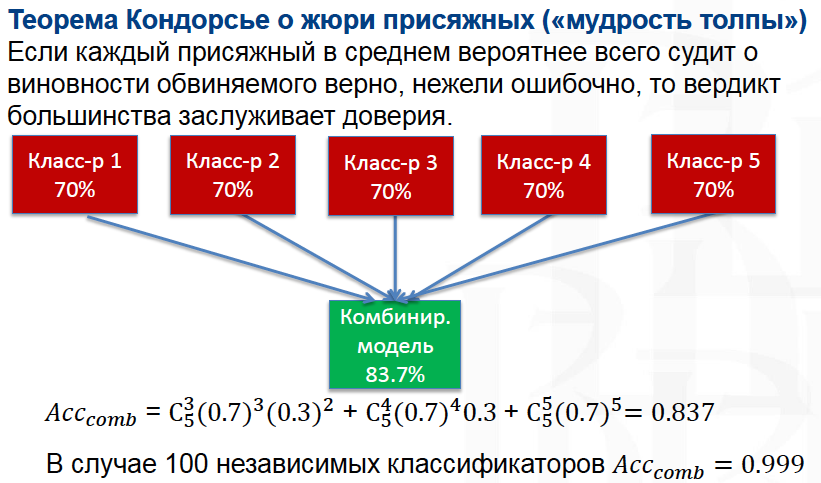

Помимо этого:
- ансамбли сглаживают границы
- ансамбли помогают бороться с High Variance

То есть использование ансамблевых методов позволяет бороться и с недообучением, и с переобучением моделей.

## Беггинг


Bagging, или Bootstrap Aggregating, – это метод ансамблевого обучения, используемый в задачах машинного обучения для улучшения стабильности и точности алгоритмов. Этот метод работает следующим образом:

1. __Создание подвыборок данных__: Bagging начинается с того, что из исходного набора данных создаются множественные подвыборки. Эти подвыборки формируются с помощью процесса, называемого бутстрэппингом, который включает в себя случайную выборку с возвращением. Это значит, что одно и то же наблюдение может появляться в подвыборке более одного раза. \
Причем, математически доказано, что __в каждую подвыборку с возвращением попадает примерно 63% исходных объектов__.
<br>


2. __Обучение моделей__: На каждой из этих подвыборок обучается отдельная предиктивная модель. Эти модели могут быть любого типа, но чаще всего используются деревья решений, особенно в случае случайных лесов, который является одним из наиболее популярных и эффективных методов bagging.
<br>


3. __Агрегирование результатов__: После обучения моделей их предсказания агрегируются для получения окончательного результата. Это может быть сделано путем усреднения предсказаний (для задач регрессии) или голосования по большинству (для задач классификации).

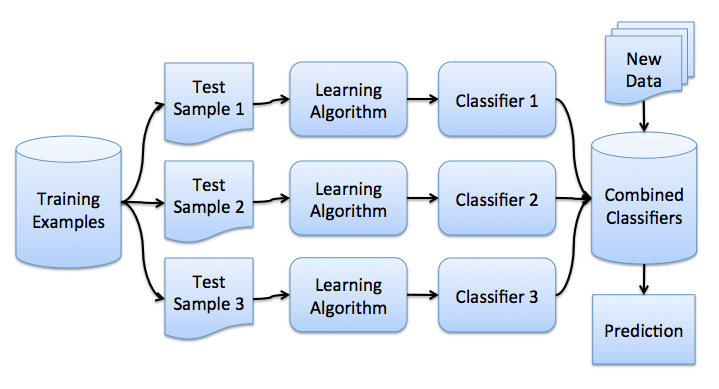

In [ ]:
from sklearn import utils

y = [0, 0, 1, 1, 1, 1, 1, 1, 1]
utils.resample(y)

In [ ]:
N = 1000 # Sample size
M = 1000 # Number of bootstrap samples
X = 50.0 + 10 * np.random.randn(N) # Initial sample

# Resampling M times with replacement from X and estimating mean every time
means = [np.mean(utils.resample(X)) for i in range(M)] 
    
sns.histplot(means, kde=True)
plt.title('Histogram of means')
plt.xlabel('Mean')
plt.show()

#### Метод случайных подпространств / attribute bagging

Метод случайных подпространств (random subspace method, "attribute bagging") аналогичен бэггингу, однако базовые алгоритмы теперь обучаются на полной выборке, но используя только случайно выбранное подмножество признаков. Данный метод эффективен в задачах с большим числом признаков и небольшим числом объектов, а также при наличии неинформативных признаков. В этих случаях классификаторы, построенные по части признакового описания, могут обладать лучшей обобщающей способностью по сравнению с классификаторами, построенными с использованием всех признаков.

#### Random patching

Данный метод является комбинацией бэггинга и метода случайных подпространств: каждый базовый классификатор обучается, используя подвыборку, сгенерированную с помощью бутстрэпа, на случайном подмножестве признаков.

Рассмотрим пример беггинга для задачи регрессии:

In [ ]:
# генерация данных
n_train = 150        
n_test = 1000       
noise = 0.1

def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) + \
        np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))
    return X, y

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
     
X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

# DecisionTree
dtree = DecisionTreeRegressor(random_state=42)

dtree.fit(X_train, y_train)
d_predict = dtree.predict(X_test)

# Bagging
btree = BaggingRegressor(DecisionTreeRegressor(), 
                         max_samples=.8, bootstrap=False,
                         n_estimators=100, random_state=42)
btree.fit(X_train, y_train)
b_predict = btree.predict(X_test)

# Random forest
forest = RandomForestRegressor(n_estimators=100, random_state=42) 
forest.fit(X_train, y_train)
f_predict = forest.predict(X_test)

fig, axs = plt.subplots( 3, 1, figsize=(8, 12))

for i in range(3):
    axs[i].plot(X_test, f(X_test), "b")
    axs[i].scatter(X_train, y_train, c="b", s=20)
    axs[i].set_xlim([-5, 5])
    
axs[0].plot(X_test, d_predict, "g", lw=2)
axs[0].set_title("Decision tree regressor, MSE = %.4f" % mean_squared_error(y_test, d_predict) )

axs[1].plot(X_test, b_predict, "r", lw=2)
axs[1].set_title("Bagged ensemble of decision tree regressors, MSE = %.4f" % mean_squared_error(y_test, b_predict) )

axs[2].plot(X_test, f_predict, "r", lw=2)
axs[2].set_title("Random forest, MSE = %.4f" % mean_squared_error(y_test, f_predict) )


plt.show()

Также посмотрим, как случайный лес разграничивает пространство признаков:

In [ ]:
from plot_decision_regions import plot_decision_regions

np.random.seed(20240406)
n_samples = 100

# первый класс
train_data = np.random.normal(size=(n_samples, 2))
train_labels = np.zeros(n_samples)

# второй класс
train_data = np.r_[train_data, np.random.normal(size=(n_samples, 2), loc=2)]
train_labels = np.r_[train_labels, np.ones(n_samples)]

In [ ]:
# разграничения "дерева решений"
dtree = DecisionTreeClassifier()

dtree.fit(train_data, train_labels)

fig, ax = plt.subplots( figsize=(6,6) )

plot_decision_regions(train_data, train_labels, dtree)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest.fit(train_data, train_labels)

fig, ax = plt.subplots( figsize=(6,6) )

plot_decision_regions(train_data, train_labels, forest)

#### ⁉️ Задание

Для датасета "voice.csv" обучите модели "Случайный лес" и BaggingClassifier.

Постройте валидационную кривую для BaggingClassfier и параметра max_samples.


In [ ]:
# ваш код здесь



## Бустинг

Бустинг (Boosting) — это ансамблевый метод, который создаёт сильный классификатор путём объединения нескольких слабых классификаторов. Идея состоит в том, чтобы последовательно добавлять модели к ансамблю, причём каждая новая модель исправляет ошибки предыдущей. Таким образом, бустинг направлен на уменьшение смещения и/или дисперсии исходного модели.

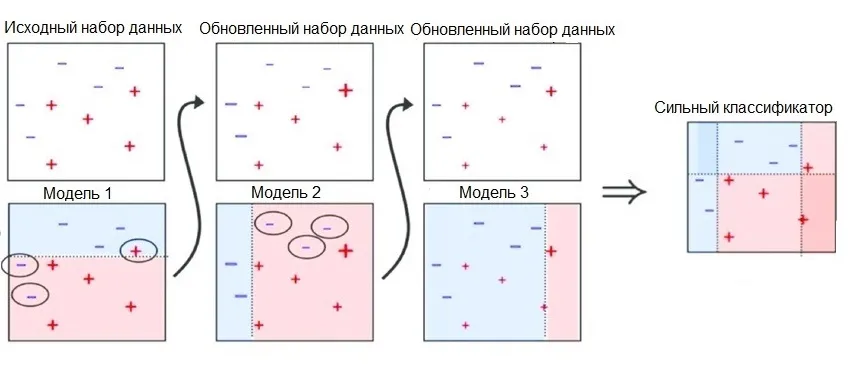

XGBoost (eXtreme Gradient Boosting) — это одна из наиболее популярных и эффективных реализаций алгоритма градиентного бустинга. XGBoost использует градиентный спуск для минимизации функции потерь: алгоритм таким образом ищет те параметры модели, при которых потери минимальны. 

Идея градиентного бустинга состоит в том, что мы рассчитываем градиент функции потерь по предсказаниям, а затем ходим сдвинуть предсказания в направлении, противоположном градиенту, и таким образом сделать их более точными.

В градиентном бустинге это делается с помощью прибавления предсказаний новой модели, которая аппроксимирует градиент со знаком минус. 

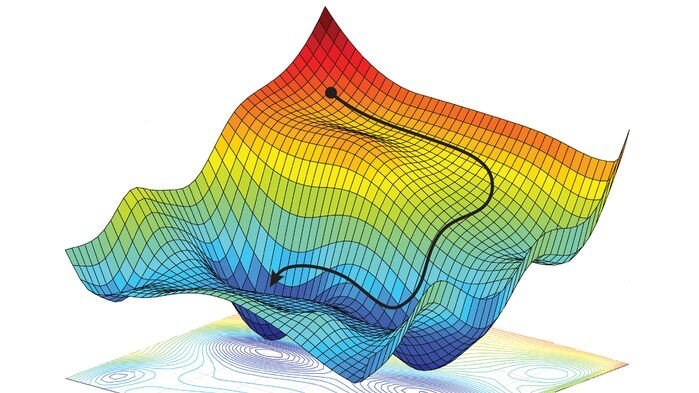



Рассмотрим применение XGBoost на примере датасета "Рукописные цифры":

In [ ]:
!pip install xgboost

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()
X, y = digits.data, digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size=0.2, 
                                                   random_state=20231110,
                                                   stratify = y)

# ваш код здесь
print(X_train.shape)
print(X_test.shape)

In [ ]:
import xgboost as xgb

model = xgb.XGBClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Accuracy score on test set: {accuracy_score(y_test, y_pred)}")

### Настройка XGBoost

XGBoost поддерживает два интерфейса:
- привычный интерфейс ```sklearn```: функции ```fit()```, ```predict()``` (пример - см. выше)
- свой собственный интерфейс, ```xgb.train()``` (см. ниже).

In [ ]:
# для работы с алгоритмом необходимо сначала создать объекты DMatrix
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

# настроим параметры
params = {
    'objective':'multi:softmax',
    'num_class': 10,
    'max_depth': 5,
    'eta': 1.
}

num_rounds = 10 # сколько итераций бустинга = сколько деревьев

xgb_model = xgb.train(params, dtrain, num_rounds)

y_pred = xgb_model.predict(dtest)

print(f"Accuracy score on test set: {accuracy_score(y_test, y_pred)}")

Теперь выполним такую же настройку для интерфейса ```sklearn```:

In [ ]:
params = {
    'objective':'multi:softmax',
    'num_class': 10,
    'max_depth': 5,
    'learning_rate': 1.0,
    'n_estimators': 10
}

model = xgb.XGBClassifier(**params)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
print(f"Accuracy score on test set: {accuracy_score(y_test, y_pred)}")
print(f"ROC-AUC score on test set: {roc_auc_score(y_test, y_pred_proba, multi_class='ovr')}")

#### ⁉️ Задание

Для датасета "voice.csv" обучите модели "Случайный лес" и классификатор XGBoost. \
Подберите конфигурацию модели XGBoost с помощью валидационной кривой или GridSearchCV.

In [ ]:
from sklearn.model_selection import validation_curve

def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)
    
voice = pd.read_csv("data/voice.csv")
voice['label_num'] = pd.factorize(voice.label)[0]
voice.drop(['label'], axis=1, inplace=True)
voice

In [ ]:
# ваш код здесь



## Интерпретация моделей

Из моделей XGBoost и RandomForest можно извлечь информацию о степени влиянии отдельных признаков на целевой признак. Это можно получить из свойства ```feature_importances_``` модели.

Рассмотрим на примере датасета "Качество вина":

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=";")

X = wine_data.drop('quality', axis=1)
y = wine_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
wine_data

Для "Случайного леса":

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

global_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()

In [ ]:
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

global_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

Можно добавить в датасет "случайную" фичу:

In [ ]:
X_train_random = X_train.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train.shape[0])

rf_random = RandomForestRegressor(n_estimators=100, random_state=42)
rf_random.fit(X_train_random, y_train)

imp_rand = pd.Series(rf_random.feature_importances_, index=X_train_random.columns)
imp_rand.sort_values(ascending=True, inplace=True)
imp_rand.plot.barh(color=list(map(lambda x: 'red' if x=='RANDOM' else 'green', imp_rand.index))
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("XGBoost Feature Importance")
plt.show()

#### ⁉️ Задание

Для датасета "voice.csv" обучите модели "Случайный лес" и классификатор XGBoost.
- Получите значение feature importances. 
- Удалите "незначительные" фичи.
- Снова обучите модели на этом датасете. Сделайте выводы.

In [ ]:
# ваш код здесь



## Категориальный бустинг

Реализован в библиотеке CatBoost (c)Yandex. Модель автоматически берёт на себя задачу кодирования категорий, что упрощает процесс и повышает качество по сравнению с примитивным One-Hot или Label Encoding.

Посмотрим пример на датасете **Car Evaluation Dataset** из репозитория UCI Machine Learning. Этот датасет удобен тем, что в нём практически все признаки являются категориальными, а задача – классифицировать автомобили по уровню их пригодности (acceptable/unacceptable/good/very good).

Оригинал датасета: https://archive.ics.uci.edu/dataset/19/car+evaluation



In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

# Допустим, у вас скачан файл car.data, лежит в рабочей директории
# В нём 7 столбцов без заголовков
column_names = [
    'buying',     # price of the car (v-high, high, med, low)
    'maint',      # maintenance cost (v-high, high, med, low)
    'doors',      # number of doors (2, 3, 4, 5-more)
    'persons',    # capacity in terms of persons to carry (2, 4, more)
    'lug_boot',   # size of luggage boot (small, med, big)
    'safety',     # estimated safety of the car (low, med, high)
    'class'       # car acceptability (unacc, acc, good, vgood)
]

df = pd.read_csv('data/car.csv', names=column_names)

# Посмотрим, что получилось
# print(df.head())  # Для отладки

# Целевая переменная — это столбец 'class'
y = df['class']
# Остальные столбцы идут в качестве признаков
X = df.drop('class', axis=1)

# Все шесть признаков у нас категориальные
cat_features = list(X.columns)  # ['buying','maint','doors','persons','lug_boot','safety']

# Разделяем на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # чтобы пропорции классов в train/test были примерно одинаковы
)

# Инициализируем модель CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,       # число деревьев
    depth=4,              # глубина деревьев
    learning_rate=0.1,    # скорость обучения
    cat_features=cat_features,  # указываем, какие признаки считать категориальными
    verbose=False,        # отключаем детальный лог
    random_seed=42
)

# Обучаем модель
model.fit(X_train, y_train)

# Предсказываем на тесте
y_pred = model.predict(X_test)

# Оцениваем качество
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test: {accuracy:.4f}")

# Важность признаков
feature_importances = model.get_feature_importance(prettified=True)
print("Feature importances:")
print(feature_importances)

In [ ]:
y_pred

#### ⁉️ Задание

Для датасета "bank.csv" обучите модели CatBoost и XGBoost.
- Выберите и сравните метрики. Сделайте выводы.

In [ ]:
# ваш код здесь



## Используемые материалы и полезные ссылки

- [CatBoost, XGBoost и выразительная способность решающих деревьев (статья на Хабре)](https://habr.com/ru/companies/ods/articles/645887/)
- [How To Get Feature Importance in Random Forests](https://forecastegy.com/posts/feature-importance-in-random-forests/)